# Gauss-Newton for XRD

In [1]:
from XRDXRFutils import GaussNewton, DataXRD, SpectraXRD, DatabaseXRD, PhaseList, PhaseMap
from matplotlib.pyplot import xlim,ylim,xlabel,ylabel,legend,plot,fill_between,imshow,subplots,sca,savefig,figure,colorbar
from numpy import prod,array,minimum,maximum,log,zeros,trapz,where,amax,max,sqrt,sign,fabs,exp,linspace
from numpy.linalg import eig,det
from multiprocessing import Pool

### loading data

In [2]:
path_xrd = '../../dati/Oslo/Profilo/XRD/'
#path_xrd = '/home/zdenek/Projects/pyMaXRDXRF/M491/ProfiloXRD/'

path_database = '../../dati/Database/'
#path_database = '/home/zdenek/Projects/XRDXRFutils/Database'

data = DataXRD().load_h5(path_xrd + 'xrd.h5')
#data.calibrate_from_file(path_xrd + 'calibration.ini')
data.calibrate_from_parameters([-1186.6, 1960.3, 51])

database = DatabaseXRD().read_cifs(path_database)

lazurite = database['Lazurite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][1]
barite = database['Barite'][0]
spinel = database['Spinel'][0]
calcite = database['Calcite'][0]
hematite = database['Hematite'][4]

phases = PhaseList([hydrocerussite,lazurite,cinnabar])
#phases = PhaseList([hydrocerussite,lazurite,cinnabar,
                    #PhaseList([hydrocerussite,cinnabar]),
                    #PhaseList([hydrocerussite,lazurite]),
                    #PhaseList([cinnabar,lazurite])])

min_theta = 0
max_theta = 53
min_intensity = 0.05
first_n_peaks = None

Loading: ../../dati/Oslo/Profilo/XRD/xrd.h5


In [3]:
%%time
pm = PhaseMap(data, phases, min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)

CPU times: user 2.4 s, sys: 3.48 s, total: 5.88 s
Wall time: 8.19 s


In [4]:
result = pm.search().list_phase_search

Process LokyProcess-8:
Traceback (most recent call last):
  File "/Users/dariozappala/miniconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/dariozappala/miniconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/dariozappala/miniconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 483, in _process_worker
    gc.collect()
KeyboardInterrupt


[-1183.09279333  1957.93601239    51.        ]


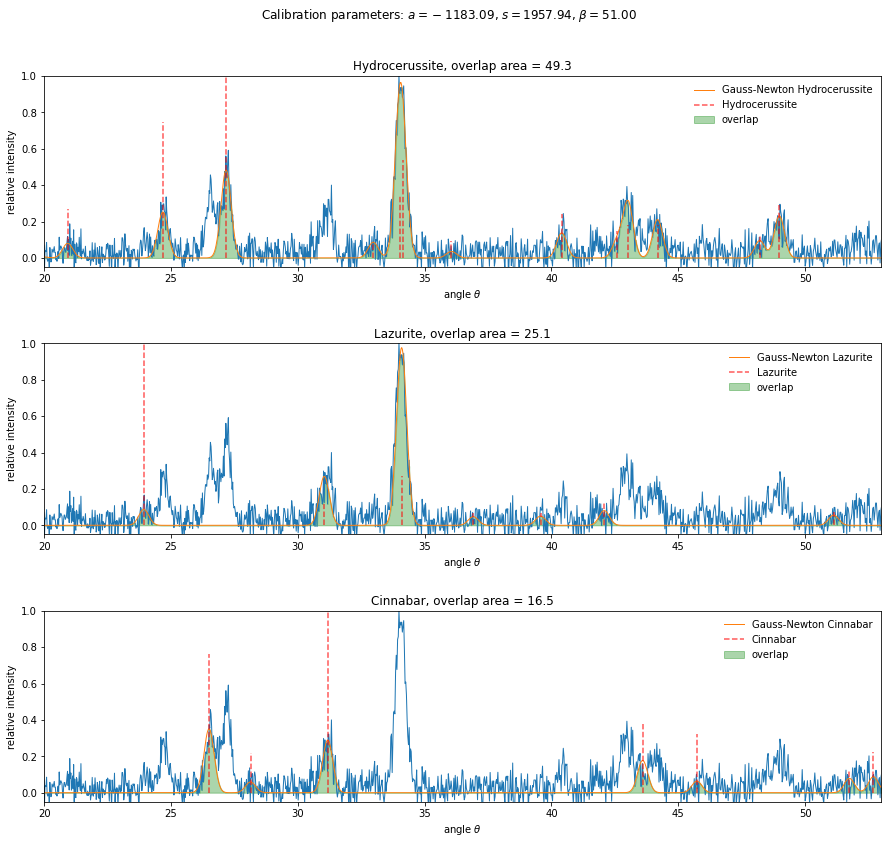

In [15]:
%matplotlib inline

r = result[1600]

fig, axes = subplots(len(r), 1, figsize = (15, 4 * len(r)))
fig.subplots_adjust(hspace = 0.4, bottom = 0.06, top = 0.9)
print(r.opt)

fig.suptitle(r'Calibration parameters: $a = %.2f$, $s=%.2f$, $\beta=%.2f$'%(r.opt[0], r.opt[1], r.opt[2]))

for i in range(len(r)):
    ax = axes[i]
    g = r[i]
    sca(ax)

    ax.set_title(f'{g.label}, overlap area = {g.overlap_area():.1f}')
    g.plot_spectra(lw = 1)
    g.plot('-', label='Gauss-Newton %s'%g.label, lw=1)
    g.phase.plot('r', alpha=0.66)

    fill_between(g.theta.squeeze(), g.overlap(), color = 'g', alpha = 0.33, label='overlap')

    legend(frameon = False)
    ax.set_ylim(-0.05, 1)
    ax.set_xlim(20, 53)
    ax.set_xlabel(r'angle $\theta$')
    ax.set_ylabel(r'relative intensity')

savefig('doc/fits.png', dpi = 900)

## Calibration

per pixel calibration dependence

a,b: [  -0.40587582 -390.77864971] [ -0.79527489 372.3774676 ]
-1186.7144672724817 1961.0328477973617


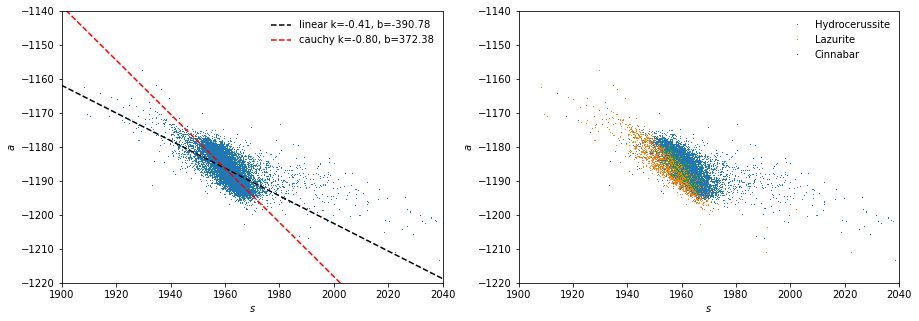

In [18]:
%matplotlib inline
from numpy import linspace
from scipy.optimize import curve_fit, least_squares

def f(x,a,b):
    return a*x + b
def loss(x,t,y):
    return (x[0]*t + x[1]) - y

a = array([r.selected.opt[0] for r in result])
s = array([r.selected.opt[1] for r in result])
idx = array([r.idx for r in result])
x = linspace(s.min(),s.max())

opt,var = curve_fit(f,s,a)

res = least_squares(loss,x0=opt,args=(s,a),loss='cauchy')
print('a,b:',opt,res['x'])

linear_y = f(x,*opt)
cauchy_y = f(x,*res['x'])

fig,ax = subplots(1,2,figsize=(15,5))

sca(ax[0])
plot(s,a,',')
plot(x,linear_y,'k--',label='linear k=%.2f, b=%.2f'%(opt[0],opt[1]))
plot(x,cauchy_y,'r--',label='cauchy k=%.2f, b=%.2f'%(res['x'][0],res['x'][1]))

legend(frameon=False)

xlabel(r'$s$')
ylabel(r'$a$')
xlim(1900,2040)
ylim(-1220,-1140)

sca(ax[1])

for i,g in enumerate(r):
    plot(s[idx==i],a[idx==i],',',label=g.label)

legend(frameon=False)

xlabel(r'$s$')
ylabel(r'$a$')
xlim(1900,2040)
ylim(-1220,-1140)

print(a.mean(),s.mean())
#savefig('doc/fit_as.png')

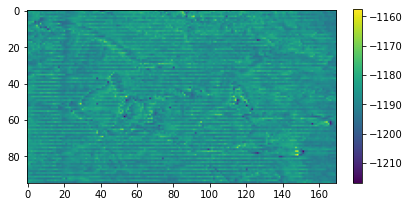

In [19]:
%matplotlib inline
ap = a.reshape(data.shape[0], data.shape[1], -1)
imshow(ap)
colorbar(fraction=0.026)
savefig('doc/acalibration.pdf')
savefig('doc/acalibration.png',dpi=1200)

## Pair compositions

In [20]:
n = len(r)
A = zeros((n,n)) # mixed area
B = zeros((n,n)) # difference

C = trapz(where(r.intensity>0,r.intensity,0)) # C

for i,ra in enumerate(r):
    
    A[i,i] = ra.overlap_area()
    
    for j,rb in enumerate(r[i+1:]):

        union = maximum(ra.z(),rb.z())
        union = minimum(union,r.intensity)
        union = trapz(where(union > 0,union,0))
        
        A[i,i + j + 1] = union
        A[i + j + 1,i] = union
        
        difference = minimum(ra.z(),rb.z())
        difference = minimum(difference,r.intensity)
        difference = trapz(where(difference > 0,difference,0))
        
        B[i,i + j + 1] = difference
        B[i + j + 1,i] = difference

(array([[49.34987403, 57.37674111, 63.94939617],
        [57.37674111, 25.13450218, 37.94484125],
        [63.94939617, 37.94484125, 16.46786272]]),
 array([[ 0.        , 17.1076351 ,  1.86834058],
        [17.1076351 ,  0.        ,  3.65752365],
        [ 1.86834058,  3.65752365,  0.        ]]),
 array([[1.        , 0.70183676, 0.97078408],
        [0.70183676, 1.        , 0.90360946],
        [0.97078408, 0.90360946, 1.        ]]))

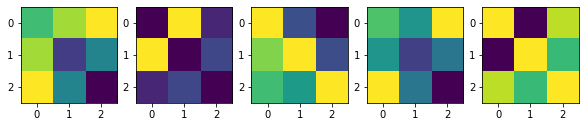

In [21]:
%matplotlib inline

fig,ax = subplots(1,5,figsize=(10,3))
ax[0].imshow(A)
ax[1].imshow(B)

ax[2].imshow(A.diagonal()/A)
ax[3].imshow((A-B))
ax[4].imshow((A-B)/A)

A,B,((A-B)/A)

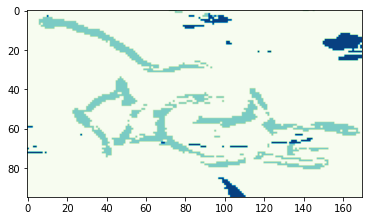

In [22]:
%matplotlib inline
idx = pm.map_best_index()
imshow(idx,cmap='GnBu')

In [23]:
%%time
area = pm.overlap_area()

CPU times: user 6.02 s, sys: 6.89 s, total: 12.9 s
Wall time: 39.8 s


In [24]:
%%time
area_fit = pm.area_fit()

CPU times: user 5.32 s, sys: 3.85 s, total: 9.17 s
Wall time: 20 s


In [25]:
%%time
area_0 = pm.area_0()

CPU times: user 5.79 s, sys: 3.51 s, total: 9.29 s
Wall time: 15.8 s


In [26]:
%%time
loss = pm.loss()

CPU times: user 7.63 s, sys: 3.83 s, total: 11.5 s
Wall time: 19.9 s


In [27]:
%%time
ss = pm.map_intensity()

CPU times: user 110 ms, sys: 409 ms, total: 519 ms
Wall time: 2.5 s


In [31]:
%matplotlib qt

fig, ax = subplots(1, 3, figsize = (3.5 * len(r), 3))
fig.subplots_adjust(wspace=0.1,hspace=0.2,top=0.95,bottom=0.05,left=0.04,right=0.985)

for i,g in enumerate(r):
    
    ax[i].imshow(area[:,:,i]/ss,vmin=0,vmax=1)
    ax[i].set_title(r'%s'%g.label)
    
#savefig('doc/maps.png')

In [33]:
%matplotlib inline
%matplotlib qt

fig, ax = subplots(1, 3, figsize = (3.5 * len(r), 3))
fig.subplots_adjust(wspace=0.1,hspace=0.2,top=0.95,bottom=0.05,left=0.04,right=0.985)

for i,g in enumerate(r):
    
    ax[i].imshow(area_fit[:,:,i]/area_0[:,:,i],vmin=0,vmax=1)
    ax[i].set_title(r'%s'%g.label)

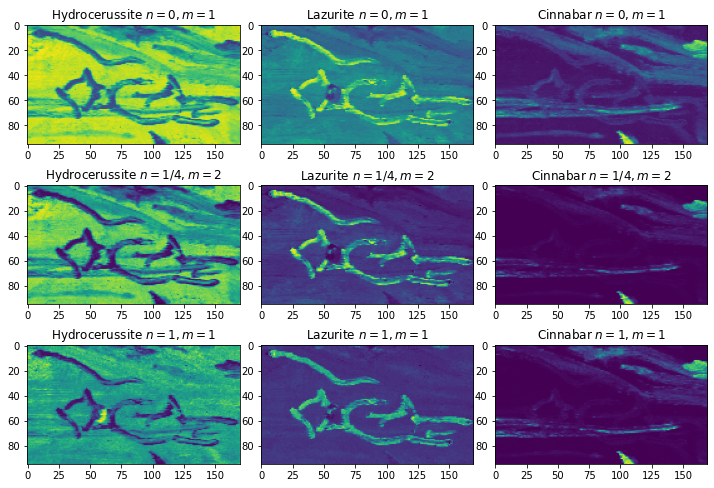

In [36]:
%matplotlib inline

fig, ax = subplots(3, len(r), figsize=(10,7))
fig.subplots_adjust(wspace=0.1,hspace=0.2,top=0.95,bottom=0.05,left=0.04,right=0.985)

for i,g in enumerate(r):
    
    ax[0,i].imshow(area[:,:,i]/ss,vmin=0)
    ax[0,i].set_title(r'%s $n = 0, m=1$'%g.label)
    
    ax[1,i].imshow(((area_fit[:,:,i]/area_0[:,:,i])**0.25 * (area[:,:,i]/ss)**2),vmin=0)
    ax[1,i].set_title(r'%s $n = 1/4, m=2$'%g.label)
    
    ax[2,i].imshow((((area_fit[:,:,i]/area_0[:,:,i]) * (area[:,:,i]/ss))),vmin=0)
    ax[2,i].set_title(r'%s $n = 1,m=1$'%g.label)
    
savefig('doc/wmaps2.png',dpi=1200)
#savefig('doc/wmaps.pdf')

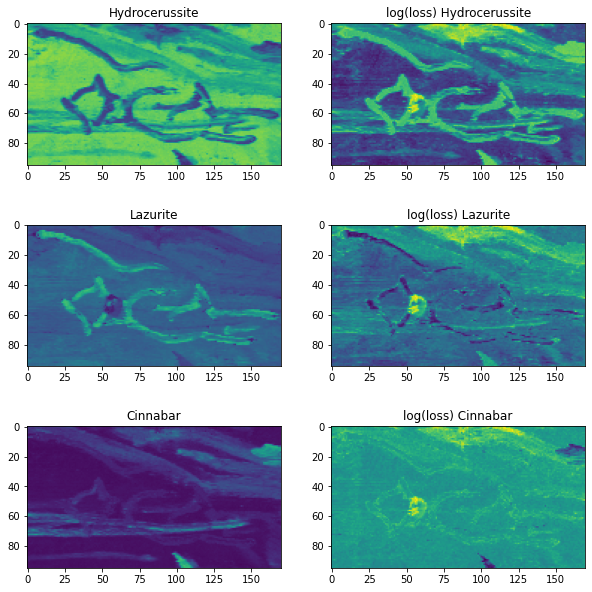

In [25]:
%matplotlib inline
fig, ax = subplots(len(r), 2, figsize = (10, 3.5 * len(r)))

for i,g in enumerate(r):

    ax[i,0].imshow(area[:,:,i]/ss,vmin=0,vmax=1)    
    ax[i,1].imshow(log(loss[:,:,i]))
    
    ax[i,0].set_title(r'%s'%g.label)
    ax[i,1].set_title(r'log(loss) %s'%g.label)

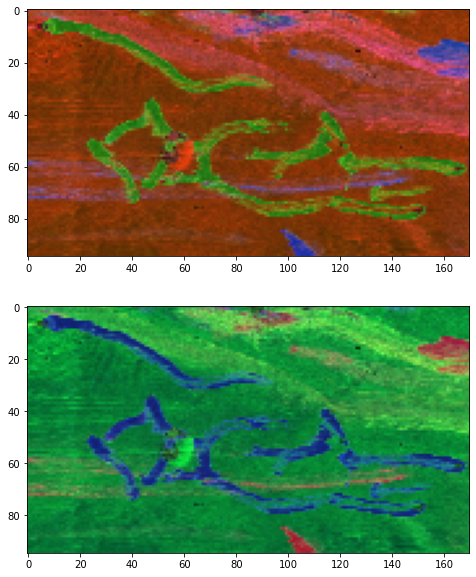

In [26]:
fig, ax = subplots(2, 1, figsize = (10, 10))

zarea = area / max(area)

sarea = zarea[:,:,:3].copy()

sarea[:,:,0] = zarea[:,:,2]
sarea[:,:,1] = zarea[:,:,0]
sarea[:,:,2] = zarea[:,:,1]

ax[0].imshow((zarea[:,:,:3]*255).astype(int))
ax[1].imshow((sarea*255).astype(int))